# Make prediction with trained DeepSDM

## Load packages

In [1]:
import time
import torch
import pytorch_lightning as pl
from types import SimpleNamespace
import mlflow
from pytorch_lightning.strategies import DDPStrategy
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from LitDeepSDMData import LitDeepSDMData
from LitUNetSDM import LitUNetSDM
import os
from matplotlib import pyplot as plt

/home/shensf/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model configuration
Some settings do not matter here. Just copy these configs from 02_train_deepsdm.py

In [2]:
# List those environment rasters for training, must be equal to or be a subset of env_list in step 01_prepare_data.
env_list = ['tmax', 'tmin', 'prec', 'elev']
# Those environment rasters that don't need normalization or are already normalized, e.g. PCA results.
non_normalize_env_list = []

date_list = []
# lists of selected dates for training
# format: YYYY_MM_01
# The python range exclude the stop value (here e.g. 2020)
# So here we generate from 2016_01_01 to 2019_12_01
# We keep data of 2020 for validation/prediction
for y_ in range(2016, 2020):
    for m_ in range(1, 13):
        date_list.append(f'{y_:04d}_{m_:02d}_01')

# list of species that selected for training
species_list = ['Psilopogon_nuchalis', 'Yuhina_brunneiceps', 'Corvus_macrorhynchos', 'Zosterops_simplex', 'Passer_montanus', 'Spilopelia_chinensis', 'Acridotheres_javanicus']

# lists of species and dates for smooth visualization preview
date_list_smoothviz = ['2020_01_01', '2020_04_01', '2020_07_01', '2020_10_01']
species_list_smoothviz = ['Psilopogon_nuchalis', 'Yuhina_brunneiceps', 'Corvus_macrorhynchos']

# packed the species lists and date lists for training
info = SimpleNamespace(**dict(
    env_list = sorted(env_list),
    non_normalize_env_list = sorted(non_normalize_env_list),
    species_list = sorted(species_list),
    species_list_val = sorted(species_list),
    species_list_smoothviz = sorted(species_list_smoothviz),
    date_list = sorted(date_list),
    date_list_val = sorted(date_list),
    date_list_smoothviz = sorted(date_list_smoothviz)
))


# We should find a relatively decent effective batch size
# The effective batch size = base_batch_size * num_train_subsample_stacks * num_of_devices * num_of_nodes
conf = SimpleNamespace(**dict(
    experiment_name = "DeepSDM DEMO",
    epochs = 300, # Change the values according to any baseline result. For example, if the training stops at epoch 300 and the metric monitored is still ascending (descending), extend this value
    base_batch_size = 64, # modify this value if OOM (out of cude memory) encountered
    num_vector = 64, # number of vectors for the embeddings of species co-occurrence
    num_env = len(env_list), # number of environmental layers
    num_train_subsample_stacks = 2, # the number of random training subsamples that sampled from the training grids
    num_val_subsample_stacks = 1, # the number of validation subsamples that sampled from the validation grids
    subsample_height = 56, # must be 8 * N, for the requirements of UNET
    subsample_width = 56, # must be 8 * N, for the requirements of UNET
    num_smoothviz_steps = 7, # the steps for smooth visualization, must be a factor of 56, the higher the smoother, and slower
    num_predict_steps = 14, # the steps for smooth visualization, must be a factor of 56, the higher the smoother, and slower
    learning_rate = 1e-4, # Usually you don't have to change this
    k2 = 1, # TODO: wait for Chile to describe
    k3 = 1/12, # TODO: wait for Chile to describe
    p = 1/3 # TODO: wait for Chile to describe
))


## Load parameters from the checkpoint of a trained model

Find the latest version or assign the version yourself under the lightning_logs directory and load parameters from its checkpoints.

In [3]:
path = 'lightning_logs'
only_dirs = [d for d in os.listdir('lightning_logs') if os.path.isdir(os.path.join(path, d)) and not d.endswith('.ipynb_checkpoints')]
sorted_dirs = sorted(only_dirs, key=lambda x: os.path.getmtime(os.path.join(path, x)))
# version = sorted_dirs[-1]
version = 'version_0'
checkpoint_path = f'{path}/{version}/checkpoints'
checkpoints = [f for f in os.listdir(checkpoint_path) if f.endswith('.ckpt') and f != 'last.ckpt']
checkpoints

['epoch=122-step=1476.ckpt']

In [4]:
model = LitUNetSDM.load_from_checkpoint(f'{checkpoint_path}/{checkpoints[0]}', info=info, conf=conf)

## Initialize datamodel

In [5]:
deep_sdm_data = LitDeepSDMData(info=info, conf=conf)

./workspace/env_information.json
./workspace/species_information.json
./workspace/k_information.json
./workspace/cooccurrence_vector.json


## Select the species and dates for prediction.
The format of date must be YYYY_MM_01

In [6]:
# The Carpodacus_formosanus is a species unknown to the model in the training process.
# We can still predict its distribution with help of species embeddings.
# We can also assign multiple species and dates for batch predictions. 
species_list_predict = ['Dicrurus_macrocercus']
date_list_predict = ['2020_09_01']
predict_dataloaders = deep_sdm_data.predict_dataloader(species_list=species_list_predict, date_list=date_list_predict)

Setting up dataset for prediction...


## Start prediction
The results inlcuding png images and geotiff will be output to the `output_dir`

In [7]:
model.eval()
with torch.no_grad():
    raw_results = model.predict(predict_dataloaders, datamodule=deep_sdm_data, output_dir='predicts')

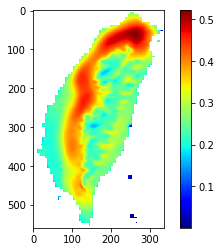

In [8]:
plt.imshow(
    raw_results['Dicrurus_macrocercus_2020-09-01'][1],
    cmap='jet',
)
plt.colorbar()